In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
import pandas as pd
import time
import datetime
from pyhdf.SD import SD, SDC
from pyhdf import HDF, VS, V


In [2]:
#For a single csat file, make a funcition that takes in a file and returns stats of the cloud layers

def csat_stats(path):
    def oneddata(path,searchdatasetlist):
        if type(path)==str:
            h=HDF.HDF(path)
        else:
            h=path
        datasetlist=[]
        for i in searchdatasetlist:
            vs=h.vstart()
            xid=vs.find(i)
            dataid=vs.attach(xid)
            dataid.setfields(i)
            nrecs,_,_,_,_=dataid.inquire()
            data=dataid.read(nRec=nrecs)
            data=list(np.concatenate(data))
            datasetlist.append(data)
            dataid.detach()
            vs.end()
        return datasetlist

    lat, lon, landseaflag = oneddata(path,['Latitude','Longitude', 'Navigation_land_sea_flag'])
    csatfile = SD(path, SDC.READ)
    toparray = np.array(csatfile.select('CloudLayerTop'))
    toparray[toparray==-99.0] = np.nan
    bottomarray = np.array(csatfile.select('CloudLayerBase'))
    bottomarray[bottomarray==-99.0] = np.nan
    typearray = np.array(csatfile.select('CloudLayerType'),dtype=np.float64)
    typearray[typearray==-9.0] = np.nan


    #Make a dataframe and add every non-nan value of typearray to it, along with corresponding lat, lon, and landseaflag

    # df = pd.DataFrame(columns=['type','lat','lon','top','bottom','landseaflag'])
    # for i in range(len(typearray)):
    #     for j in range(len(typearray[i])):
    #         df.loc[len(df)] = [typearray[i][j],lat[i],lon[i],toparray[i][j],bottomarray[i][j],landseaflag[i]]
    #Remove all rows with nan values

    #print(toparray[7346])
    #print(bottomarray[7346])
    
    indices = np.where(~np.isnan(typearray)) #Returns a tuple of arrays, one for each dimension of a, containing the indices of the non-nan elements.
    typearray = typearray[indices] #Extracting the type of cloud for each non-nan value (i.e. a cloud or clear case)
    #print(type(lat))
    lat = np.take(lat,(indices[0])) #To access elements of list using a 1D array. 
    lon = np.take(lon,(indices[0]))
    landseaflag = np.take(landseaflag,(indices[0]))
    toparray = toparray[indices]
    bottomarray = bottomarray[indices]
    df = pd.DataFrame(columns=['type','lat','lon','top','bottom','landseaflag'])

    df['type'] = typearray
    df['lat'] = lat
    df['lon'] = lon
    df['top'] = toparray
    df['bottom'] = bottomarray
    df['landseaflag'] = landseaflag
    df['thickness'] = df['top'] - df['bottom']
    
    return df

        

    
#    return typearray


In [64]:
l=[1,2,3,4,5,6,7,8,9]
array= np.array([1,2,3])
np.take(l,array)

array([2, 3, 4])

In [97]:
path = r'/data/debasish/cloudsatdata/cldclasslidar/2019jan/day01/2019001005530_67526_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf'
start=time.time()
dump=csat_stats(path)
end=time.time()
print(end-start)

[2.1699986       nan       nan       nan       nan       nan       nan
       nan       nan       nan]
[1.0299995       nan       nan       nan       nan       nan       nan
       nan       nan       nan]
<class 'list'>
1.6459321975708008


In [98]:
zeroless = dump[dump['type']!=0]
#Drop all indecies
zeroless = zeroless.reset_index(drop=True)
#zeroless['thickness'] = zeroless['top']-zeroless['bottom']
#zeroless.head(5)
#Print all the rows for which type is 1
zeroless[zeroless['type']==1]



,type,lat,lon,top,bottom,landseaflag,thickness
2402,1.0,-71.247879,-149.504196,6.130012,5.950010,2,0.180001
2404,1.0,-71.239189,-149.518112,6.130012,5.950010,2,0.180001
2406,1.0,-71.230499,-149.531998,6.130012,5.950010,2,0.180001
2408,1.0,-71.221809,-149.545837,6.130012,5.950010,2,0.180001
2410,1.0,-71.213112,-149.559677,6.010011,5.890010,2,0.120001
...,...,...,...,...,...,...,...
18034,1.0,46.137890,168.907288,8.350000,8.020024,2,0.329976
18037,1.0,46.147438,168.903748,8.350000,8.020024,2,0.329976
20884,1.0,68.376175,154.756287,7.030018,6.670015,1,0.360003
20887,1.0,68.385147,154.745514,7.030018,6.610015,1,0.420003


<AxesSubplot:>

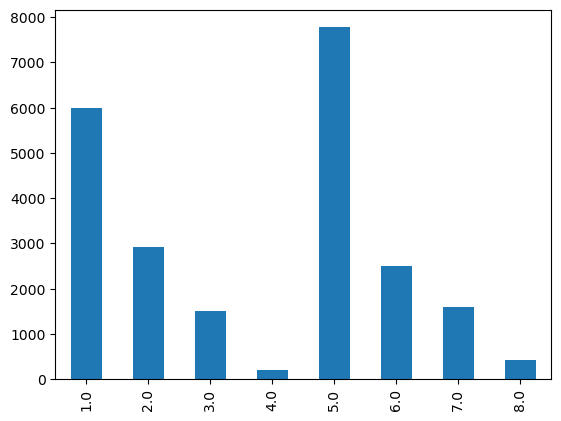

In [90]:
#Count the number of each type of cloud and arrange the cloud type in ascending order of their number
zeroless['type'].value_counts().sort_index()
#Plot it
zeroless['type'].value_counts().sort_index().plot(kind='bar')

In [3]:
#Apply the above function on each file in the directory /data/debasish/cloudsatdata/cldclasslidar/2019jan/day01

import os
import glob

path = r'/data/debasish/cloudsatdata/cldclasslidar/2019jan/day01'

files = glob.glob(os.path.join(path, '*.hdf'))
files.sort()
print(files)
print(type(files))

['/data/debasish/cloudsatdata/cldclasslidar/2019jan/day01/2019001005530_67526_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf', '/data/debasish/cloudsatdata/cldclasslidar/2019jan/day01/2019001023402_67527_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf', '/data/debasish/cloudsatdata/cldclasslidar/2019jan/day01/2019001041234_67528_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf', '/data/debasish/cloudsatdata/cldclasslidar/2019jan/day01/2019001055106_67529_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf', '/data/debasish/cloudsatdata/cldclasslidar/2019jan/day01/2019001072938_67530_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf', '/data/debasish/cloudsatdata/cldclasslidar/2019jan/day01/2019001090810_67531_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf', '/data/debasish/cloudsatdata/cldclasslidar/2019jan/day01/2019001104642_67532_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf', '/data/debasish/cloudsatdata/cldclasslidar/2019jan/day01/2019001122514_67533_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R

In [110]:
#Applying funciton on one whole day

df=csat_stats(files[0])
df=df[df['type']!=0]
for i in range(1,len(files)):
    oneorbit=csat_stats(files[i])
    oneorbit = oneorbit[oneorbit['type']!=0]  
    #Concatenate the dataframes
    df = pd.concat([df,oneorbit],ignore_index=True)
    print("File {} is done, appeneded file length = {}".format(i,len(oneorbit)))

File 1 is done, appeneded file length = 27850
File 2 is done, appeneded file length = 20502
File 3 is done, appeneded file length = 21240
File 4 is done, appeneded file length = 20117
File 5 is done, appeneded file length = 21720
File 6 is done, appeneded file length = 19869
File 7 is done, appeneded file length = 19205
File 8 is done, appeneded file length = 19484
File 9 is done, appeneded file length = 16271
File 10 is done, appeneded file length = 18494
File 11 is done, appeneded file length = 18897
File 12 is done, appeneded file length = 23452
File 13 is done, appeneded file length = 23384
File 14 is done, appeneded file length = 22962


In [16]:
path=r'/data/debasish/cloudsatdata/cldclasslidar/2019jan/day01/2019001005530_67526_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf'
print("Total file length = 370_000")
df=csat_stats(path)
print("After removal of NaN ", len(df))
df=df[df['type']!=0]
print("After removal of 0's", len(df))

Total file length = 370_000
After removal of NaN  208590
After removal of 0's 22929


In [188]:
df['lat'].mean(),df['lon'].mean()

(-3.57415205395987, -6.7854648888158)

In [111]:
df.head(5)

,type,lat,lon,top,bottom,landseaflag,thickness
0,5.0,-69.947945,-14.953794,2.169999,1.029999,2,1.139999
1,5.0,-69.956764,-14.966085,2.169999,0.790000,2,1.379999
2,5.0,-69.965576,-14.978376,2.169999,0.790000,2,1.379999
3,5.0,-69.974396,-14.990705,2.169999,0.790000,2,1.379999
4,5.0,-69.983208,-15.003057,2.049999,1.029999,2,1.019999


In [112]:
df.describe()

,type,lat,lon,top,bottom,landseaflag,thickness
count,316376.000000,316376.000000,316376.000000,316376.000000,316376.000000,316376.000000,316376.000000
mean,3.575198,-3.574152,-6.785465,6.079333,4.321483,1.793878,1.758545
std,2.003945,51.249907,109.283210,4.985710,4.442124,0.638851,2.203989
min,1.000000,-81.879036,-179.999008,0.130000,0.130000,1.000000,0.000000
25%,2.000000,-51.265272,-106.339821,1.809999,0.850000,1.000000,0.420000
50%,3.000000,-5.350963,-9.572615,4.630001,2.469998,2.000000,0.900006
75%,5.000000,43.386233,89.351170,9.430008,6.790016,2.000000,2.219998
max,8.000000,81.878571,179.998932,19.330025,19.150026,5.000000,18.840025


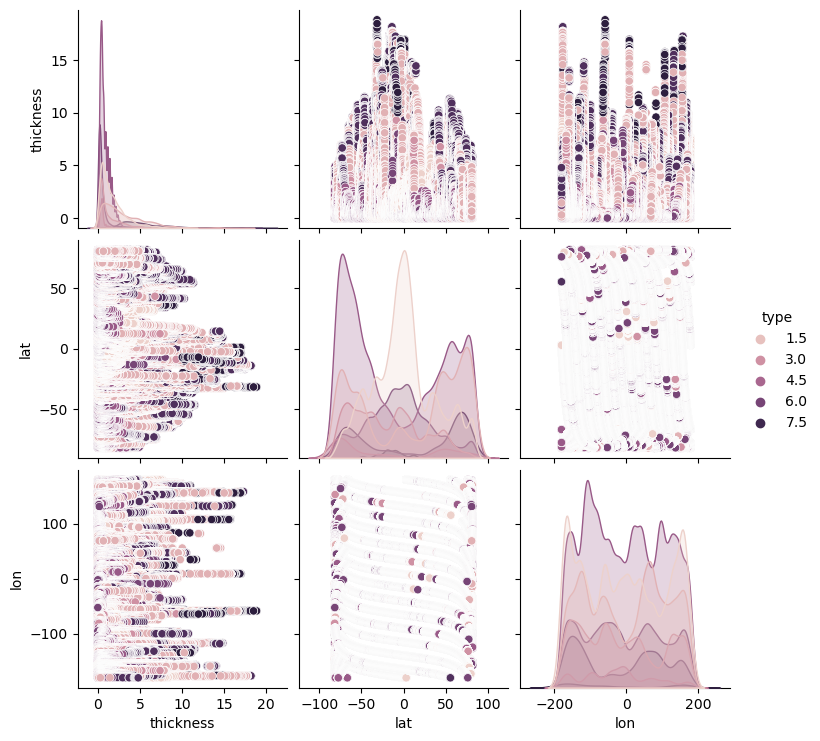

In [115]:
#Plotting the pairplot of the data

import seaborn as sns

sns.pairplot(df, hue='type',vars=['thickness','lat','lon'])

<AxesSubplot:>

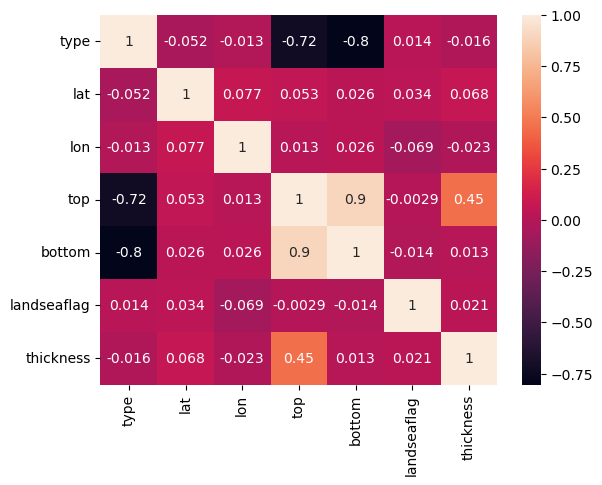

In [116]:
#Find correlation between thickness, lat, lon

df.corr()

#Plot the df.corr in a heatmap

sns.heatmap(df[df['type']].corr(),annot=True)

In [120]:
#Plot first 5 elements of all the columns except of the column landseaflag

df.loc[0:5,df.columns!='landseaflag']

,type,lat,lon,top,bottom,thickness
0,5.0,-69.947945,-14.953794,2.169999,1.029999,1.139999
1,5.0,-69.956764,-14.966085,2.169999,0.790000,1.379999
2,5.0,-69.965576,-14.978376,2.169999,0.790000,1.379999
3,5.0,-69.974396,-14.990705,2.169999,0.790000,1.379999
4,5.0,-69.983208,-15.003057,2.049999,1.029999,1.019999
5,5.0,-69.992020,-15.015409,2.169999,1.029999,1.139999


In [124]:
#Print the average thickness of each cloud type

print(df.groupby('type')['thickness'].mean())
print(df.groupby('type')['top'].mean())
print(df.groupby('type')['bottom'].mean())

type
1.0     1.702150
2.0     3.103587
3.0     1.236470
4.0     0.502784
5.0     0.813939
6.0     0.641145
7.0     5.693262
8.0    11.276657
Name: thickness, dtype: float32
type
1.0    12.963213
2.0     7.882422
3.0     4.807239
4.0     1.308197
5.0     1.957798
6.0     1.588153
7.0     7.015226
8.0    12.136624
Name: top, dtype: float32
type
1.0    11.261063
2.0     4.778835
3.0     3.570770
4.0     0.805413
5.0     1.143860
6.0     0.947008
7.0     1.321963
8.0     0.859968
Name: bottom, dtype: float32


In [136]:
cloudtype_dict={1:'Cirrus',2:'Altostratus',3:'Altocumulus',4:'Stratus',5:'Stratocumulus',6:'Cumulus',7:'Nimbostratus'
                ,8:'Deep convective'}

cloudlabel=np.arange(1,9)

#Access a cloud type name using its number
cloudtype_dict[1]

'Cirrus'

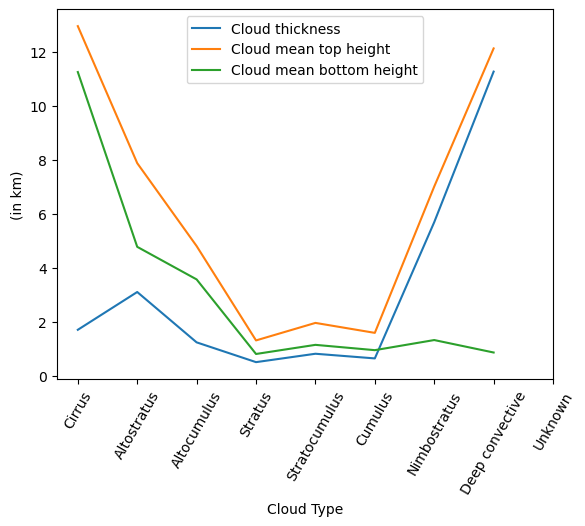

In [186]:
plt.plot(df.groupby('type')['thickness'].mean(),label='Cloud thickness')
plt.plot(df.groupby('type')['top'].mean(),label='Cloud mean top height')
plt.plot(df.groupby('type')['bottom'].mean(),label='Cloud mean bottom height')
plt.xlabel('Cloud Type')
plt.ylabel('(in km)')
plt.xticks(cloudlabel,cloudtype_dict.values(),rotation=60);
plt.legend()

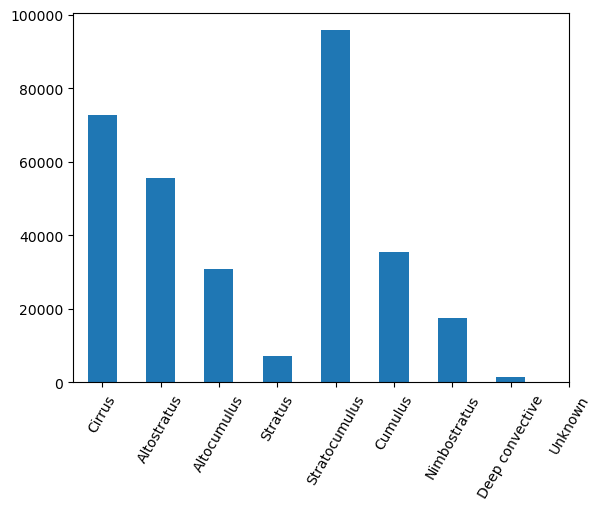

In [141]:
#Find the abundance of each cloud type in the dataset

df['type'].value_counts().sort_index()

#Plot the abundance of each cloud type in the dataset

df['type'].value_counts().sort_index().plot(kind='bar')
#Put the cloud type name on the x-axis
plt.xticks(cloudlabel-1,cloudtype_dict.values(),rotation=60);

In [142]:
#Find the fractional abundance of each cloud type in the dataset

df['type'].value_counts().sort_index()/len(df)

1.0    0.229711
2.0    0.175364
3.0    0.097672
4.0    0.022492
5.0    0.302365
6.0    0.111769
7.0    0.055681
8.0    0.004947
Name: type, dtype: float64

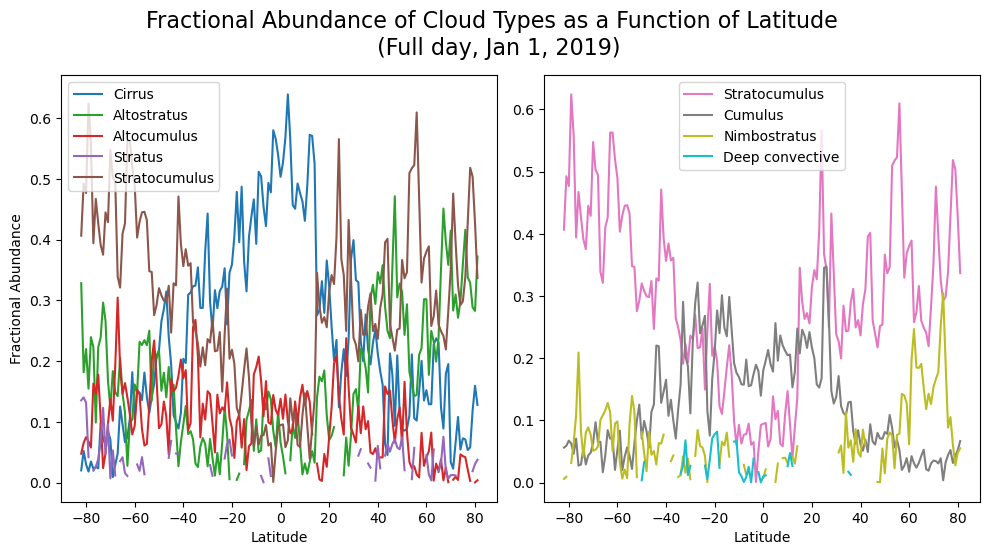

In [185]:
#Make a figure of two subplots side by side and of equal size

fig,ax=plt.subplots(1,2,figsize=(10,5))
plt.figtext(0.5,1.051,'Fractional Abundance of Cloud Types as a Function of Latitude \n (Full day, Jan 1, 2019)',ha='center', va='center',fontsize=16)
#Plot the fractional abundance of each cloud type in the dataset
dfcopy = df.copy()
dfcopy['latbin']=np.floor(dfcopy['lat'])
dfcopy['latbin'].value_counts().sort_index()

import matplotlib.cm as cm

# colors_subplot_1 = cm.rainbow(np.linspace(0, 0.5, 5)) #One way of getting colors
# colors_subplot_2 = cm.rainbow(np.linspace(0.5, 1, 4))

from matplotlib.colors import Normalize, PowerNorm
from matplotlib.cm import get_cmap

norm = PowerNorm(gamma=0.7) #Sharper colors with better contrast
cmap = get_cmap("tab10")
colors = cmap(norm(np.linspace(0, 1, 10)))

colors_subplot_1 = colors[0:5]
colors_subplot_2 = colors[5:9]

for i, c in enumerate(colors_subplot_1):
    ax[0].plot(dfcopy[dfcopy['type']==i+1].groupby('latbin')['type'].count()/dfcopy.groupby('latbin')['type'].count(),label=cloudtype_dict[i+1], color=c)
    ax[0].set_xlabel('Latitude')
    ax[0].set_ylabel('Fractional Abundance')
    ax[0].legend(loc='upper left')

for i, c in enumerate(colors_subplot_2):
    ax[1].plot(dfcopy[dfcopy['type']==i+5].groupby('latbin')['type'].count()/dfcopy.groupby('latbin')['type'].count(),label=cloudtype_dict[i+5], color=c)
    ax[1].set_xlabel('Latitude')
    #ax[1].set_ylabel('Fractional Abundance')
    ax[1].legend()

plt.tight_layout()


In [187]:
len(df)

316376

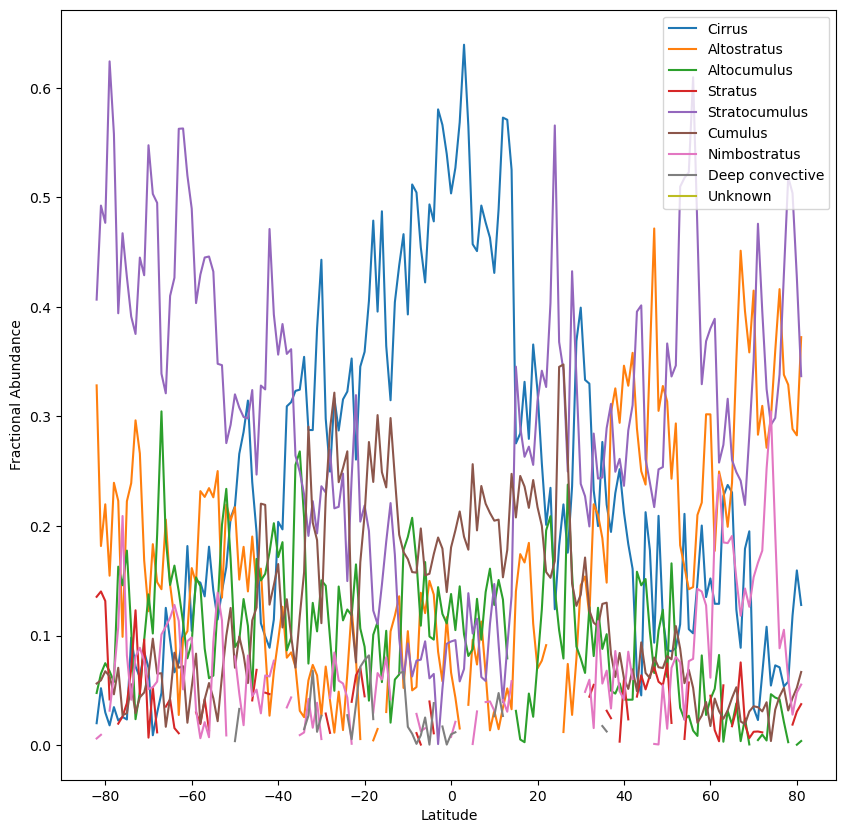

In [148]:
#Convert the latitude into bins of 1 degree and find the fractional abundance of each cloud type in each bin

dfcopy = df.copy()
dfcopy['latbin']=np.floor(dfcopy['lat'])
dfcopy['latbin'].value_counts().sort_index()

#Plot the fractional abundance of each cloud type in each bin so that plot is not too crowded

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,10))
#Add two subplots
ax1=fig.add_subplot(211)
ax=fig.add_subplot(111)



for i in range(1,5):
    plt.plot(dfcopy[dfcopy['type']==i].groupby('latbin')['type'].count()/dfcopy.groupby('latbin')['type'].count(),label=cloudtype_dict[i])
    plt.legend()
    plt.xlabel('Latitude')
    plt.ylabel('Fractional Abundance')

fig2=plt.figure(figsize=(10,10))


# for i in range(1,10):
#     plt.plot(dfcopy[dfcopy['type']==i].groupby('latbin')['type'].count()/dfcopy.groupby('latbin')['type'].count(),label=cloudtype_dict[i])
#     plt.legend()
#     plt.xlabel('Latitude')
#     plt.ylabel('Fractional Abundance')

In [144]:
dfcopy[dfcopy['type']==i].groupby('latbin')['type'].count()

Series([], Name: type, dtype: int64)

In [7]:
#Just testing if we can read data that are in read-only mode (yes, we can)
path = r'/data/debasish/cloudsatdata/cldclasslidar/2013224032834_38782_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E06_F00.hdf'

#Read the HDF file
hdf = SD(path, SDC.READ)
dump = np.array(hdf.select('CloudLayerTop'))
dump[20000:20005,:]

array([[ 10.630016,  16.030054, -99.      , -99.      , -99.      ,
        -99.      , -99.      , -99.      , -99.      , -99.      ],
       [ 10.150013,  16.030054, -99.      , -99.      , -99.      ,
        -99.      , -99.      , -99.      , -99.      , -99.      ],
       [  9.910011,  15.970054, -99.      , -99.      , -99.      ,
        -99.      , -99.      , -99.      , -99.      , -99.      ],
       [  9.67001 ,  12.790031,  16.090054, -99.      , -99.      ,
        -99.      , -99.      , -99.      , -99.      , -99.      ],
       [  9.67001 ,  12.55003 ,  16.150053, -99.      , -99.      ,
        -99.      , -99.      , -99.      , -99.      , -99.      ]],
      dtype=float32)

In [ ]:
path = r'/data/debasish/cloudsatdata/cldclasslidar/2014/2014apr/092/2014092000512_42173_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E06_F00.hdf'

#Read the HDF file
